# Style transfer

The main idea behind the project is to extract the style from one image, and combine it with the feautres from another.

The feature and content extraction is performed through the use a CNN (in this case VGG-19). 

In [1]:
import torch
import torchvision

from torch import nn
from torch import optim

from torchvision import transforms
from torchvision.models import vgg19, VGG19_Weights


from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
torch.backends.cudnn.benchmark = True
print(device)

cuda:0


### Loading content and style images

VGG-19 accetta in input immagini di dimensione 224x224, normalizzate nel range [0,1].

Per una visualizzazione più gradevole delle immagini la normalizzazione è implementata come layer aggiuntivo della CNN invece di essere applicata a priori (dato il ridotto numero di immagini).

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),              
    transforms.CenterCrop(224),          
    transforms.ToTensor()
])

content_image = transform(Image.open("./content.jpg"))
content_image = content_image.clamp_(0, 1).unsqueeze(0).to(device, non_blocking = True)

style_image = transform(Image.open("./style.jpg"))
style_image = style_image.clamp_(0, 1).unsqueeze(0).to(device, non_blocking = True)

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

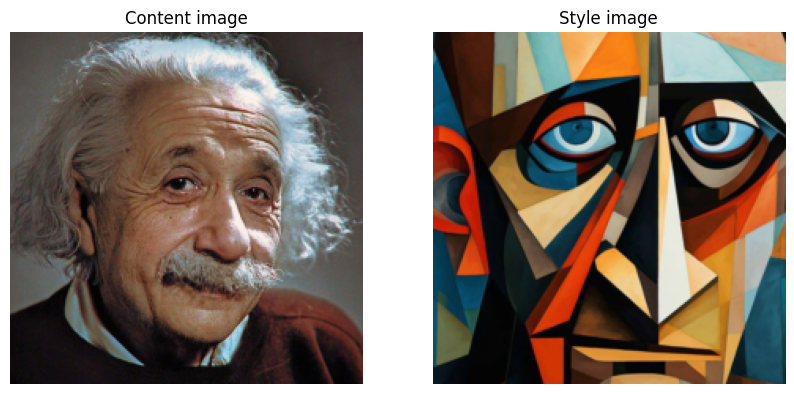

In [4]:
plt.ion()

to_pil = transforms.ToPILImage()

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

image = content_image.clone().cpu().squeeze(0)
image = to_pil(image)
axes[0].imshow(image)
axes[0].set_title("Content image")
axes[0].axis('off') 

image = style_image.clone().cpu().squeeze(0)
image = to_pil(image)
axes[1].imshow(image)
axes[1].set_title("Style image")
axes[1].axis('off') 


### Importing the model

The vgg-19 model is composed of two parts: features and classifier.

The features section extracts features from the input image and is composed of various convolutional and maxpooling layers.

The classifier section is composed of fully connected layers that wont be used in this project.

In [5]:
vgg_features = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

print(vgg_features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

As promised before we have to include a layer that normalizes the input in the [0,1] range.

In [6]:
class Normalizer(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]):
        super(Normalizer, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

### Computing loss 

The loss function is composed of two parts: 

##### Content loss
Computed as the Mean Square error between the content image and output image representations in latent space at layer 4.

##### Style loss
Computed as the Mean Square error between two matrices constructed in the forward pass of the style image and output image.

In particular those two matrices are the covariance matrices of the features in latent space at each given layer.

Layers used for computing the style loss are layer 1 to 5.


In [7]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    
    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

In [8]:
def covmat(features):
    batches, nfeatures, height, width = features.size()

    features = features.view(batches * nfeatures, height * width)

    mat = torch.mm(features, features.t())

    return mat.div(batches * nfeatures * height * width)

class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = covmat(target).detach()
    
    def forward(self, input):
        mat = covmat(input)
        self.loss = nn.functional.mse_loss(mat, self.target)
        return input


### Putting it all together

In [9]:
model = nn.Sequential(Normalizer())
style_losses = []
content_losses = []

nConv = 0
for layer in vgg_features.children():
    if isinstance(layer, nn.Conv2d):
        nConv += 1

        model.add_module("conv_{}".format(nConv), layer)

        target = model(style_image).detach()
        style_loss_layer = StyleLoss(target)
        model.add_module("style_loss_{}".format(nConv), style_loss_layer)
        style_losses.append(style_loss_layer)

        if nConv == 4:
            target = model(content_image).detach()
            content_loss_layer = ContentLoss(target)
            model.add_module("content_loss_{}".format(nConv), content_loss_layer)
            content_losses.append(content_loss_layer)
            

    elif isinstance(layer, nn.ReLU):
        layer = nn.ReLU(inplace=False)
        model.add_module("ReLu_{}".format(nConv), layer)

    elif isinstance(layer, nn.MaxPool2d):
        #layer = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        model.add_module("max_pool_{}".format(nConv), layer)

    if nConv == 5:
        break

        

print(model)

Sequential(
  (0): Normalizer()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (ReLu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (ReLu_2): ReLU()
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (ReLu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_4): StyleLoss()
  (content_loss_4): ContentLoss()
  (ReLu_4): ReLU()
  (max_pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)


### Selecting an image

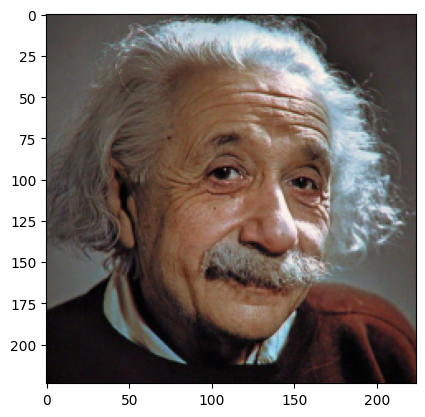

In [10]:
input_image = content_image.clone()
image = to_pil(input_image.clone().cpu().squeeze(0))
# input_image = torch.randn(content_image.data.size())
plt.figure()
plt.imshow(to_pil(input_image.squeeze(0).cpu()))

### Gradient descent

In [11]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = optim.LBFGS([input_img])

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img


In [12]:
output = run_style_transfer(model,content_image, style_image, input_image, num_steps=300, style_weight=1000000, content_weight=1)

Optimizing..
run [50]:
Style Loss : 767.433411 Content Loss: 26.986818

run [100]:
Style Loss : 222.622086 Content Loss: 31.117144

run [150]:
Style Loss : 100.761879 Content Loss: 32.870884

run [200]:
Style Loss : 56.389767 Content Loss: 33.651909

run [250]:
Style Loss : 38.064083 Content Loss: 34.023083

run [300]:
Style Loss : 28.939959 Content Loss: 33.889091



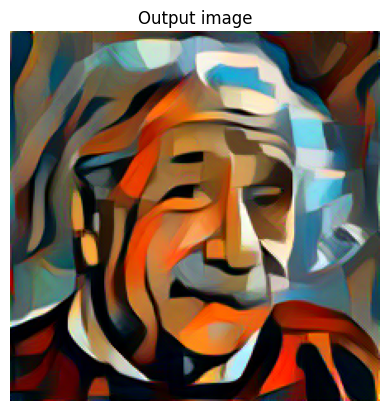

In [13]:
image = output.clone().cpu().squeeze(0)
to_pil = transforms.ToPILImage()
image = to_pil(image)#.convert('L')

plt.figure()
plt.imshow(image, cmap = "gray")
plt.title("Output image")
plt.axis("Off")
plt.show()

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

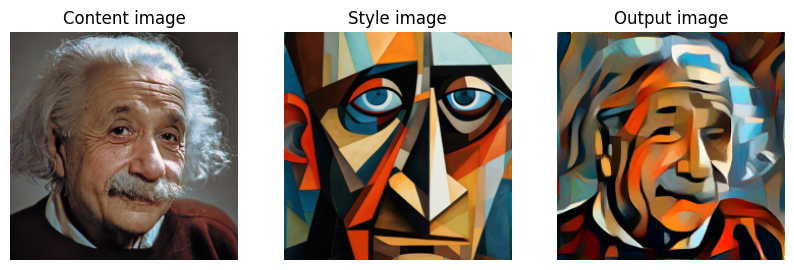

In [14]:
plt.ion()

to_pil = transforms.ToPILImage()

fig, axes = plt.subplots(1, 3, figsize=(10, 5)) 

image = content_image.clone().cpu().squeeze(0)
image = to_pil(image)
axes[0].imshow(image)
axes[0].set_title("Content image")
axes[0].axis('off') 

image = style_image.clone().cpu().squeeze(0)
image = to_pil(image)
axes[1].imshow(image)
axes[1].set_title("Style image")
axes[1].axis('off') 

image = output.clone().cpu().squeeze(0)
image = to_pil(image)
axes[2].imshow(image)
axes[2].set_title("Output image")
axes[2].axis('off') 

### 

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

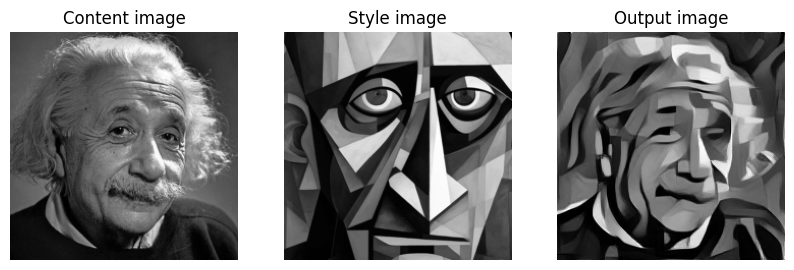

In [15]:
plt.ion()

to_pil = transforms.ToPILImage()

fig, axes = plt.subplots(1, 3, figsize=(10, 5)) 

image = content_image.clone().cpu().squeeze(0)
image = to_pil(image).convert("L")
axes[0].imshow(image, cmap = "gray")
axes[0].set_title("Content image")
axes[0].axis('off') 

image = style_image.clone().cpu().squeeze(0)
image = to_pil(image).convert("L")
axes[1].imshow(image, cmap = "gray")
axes[1].set_title("Style image")
axes[1].axis('off') 

image = output.clone().cpu().squeeze(0)
image = to_pil(image).convert("L")
axes[2].imshow(image, cmap = "gray")
axes[2].set_title("Output image")
axes[2].axis('off') 